In [0]:
import shutil
import os
import string, re
import numpy as np
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
from keras import models
from keras.engine.saving import model_from_json
from keras.optimizers import SGD
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.models import model_from_json

**Initializing GPU**

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Downloading the English chars74k Dataset from an Online Source**

In [0]:
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz

--2019-02-20 13:33:35--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133975105 (128M) [application/x-gzip]
Saving to: ‘EnglishImg.tgz’

EnglishImg.tgz      100%[===================>] 127.77M  50.8MB/s    in 2.5s    

2019-02-20 13:33:41 (50.8 MB/s) - ‘EnglishImg.tgz’ saved [133975105/133975105]



In [0]:
!gunzip EnglishImg.tgz

gzip: EnglishImg.tar already exists; do you wish to overwrite (y or n)? 

In [0]:
!tar -xvf EnglishImg.tar

English/Img/
English/Img/BadImag/
English/Img/BadImag/Bmp/
English/Img/BadImag/Bmp/Sample029/
English/Img/BadImag/Bmp/Sample029/img029-00006.png
English/Img/BadImag/Bmp/Sample029/img029-00007.png
English/Img/BadImag/Bmp/Sample029/img029-00008.png
English/Img/BadImag/Bmp/Sample029/img029-00009.png
English/Img/BadImag/Bmp/Sample029/img029-00010.png
English/Img/BadImag/Bmp/Sample029/img029-00011.png
English/Img/BadImag/Bmp/Sample029/img029-00012.png
English/Img/BadImag/Bmp/Sample029/img029-00013.png
English/Img/BadImag/Bmp/Sample029/img029-00014.png
English/Img/BadImag/Bmp/Sample029/img029-00015.png
English/Img/BadImag/Bmp/Sample029/img029-00016.png
English/Img/BadImag/Bmp/Sample029/img029-00017.png
English/Img/BadImag/Bmp/Sample029/img029-00018.png
English/Img/BadImag/Bmp/Sample029/img029-00019.png
English/Img/BadImag/Bmp/Sample029/img029-00020.png
English/Img/BadImag/Bmp/Sample029/img029-00021.png
English/Img/BadImag/Bmp/Sample029/img029-00023.png
English/Img/BadImag/Bmp/Sample029/img02

**Functions for Load Filename, Split and Save Dataset, Get Class Index and Get Class**

In [0]:
#Code framework based on https://github.com/fhennecker/chars74k
CLASSES = string.digits + string.ascii_uppercase + string.ascii_lowercase
print("Class : ", len(CLASSES))

def load_filenames(datapath, filters=[]):
    filenames = []
    for path, dirs, files in os.walk(datapath):
        if sum(map(lambda f: f in path, filters)) == len(filters):
            filenames += list(map(lambda f: path + '/' + f, files))
    return filenames

def split_and_save_dataset(dataset, filename):
    splits = [0.8, 0.2] #Splitting dataset 80-20
    split_names = ['train', 'test']
    perm = np.random.permutation(len(dataset))
    print("Here: ",dataset[1000], get_class(dataset[1000]))
    for s, split in enumerate(splits):
        startindex = int(sum(splits[:s]) * len(dataset))
        endindex = int(startindex + splits[s] * len(dataset))
        with open(filename + '_' + split_names[s], 'w') as f:
            for i in perm[startindex:endindex]:
                f.write(dataset[i] + '\n')


def get_class_index(filename):
    return int(re.findall(r'.*img(\d+).*', filename)[0]) - 1


def get_class(filename):
    return CLASSES[get_class_index(filename)]

filenames = load_filenames('English/', ['Good', 'Bmp'])
split_and_save_dataset(filenames, 'Split')
train_path = "data/train"
test_path = "data/test"
with open('Split_train', 'r') as fp:
    train = fp.readlines()
    train = [x.strip() for x in train]
    for line in train:
        splits = line.split('/')
        old_path = splits[:-1]
        categ = old_path[-1:]
        categ = "".join(categ)
        old_path = "/".join(old_path)
        filename = splits[-1:]
        filename = "".join(filename)
        print(line)
        print("Path Name: ", old_path, filename, categ)
        # os.rename(line, train_path + "/" + filename)
        try:
            shutil.copyfile(line, train_path + "/" + categ + "/" + filename)
        except FileNotFoundError:
            os.makedirs(train_path + "/" + categ)
            shutil.copyfile(line, train_path + "/" + categ + "/" + filename)
with open('Split_test', 'r') as fp:
    test = fp.readlines()
    test = [y.strip() for y in test]
    for line1 in test:
        splits1 = line1.split('/')
        old_path1 = splits1[:-1]
        categ1 = old_path1[-1:]
        categ1 = "".join(categ1)
        old_path1 = "/".join(old_path1)
        filename = splits1[-1:]
        filename = "".join(filename)
        print(line1)
        print("Path Name: ", old_path1, filename, categ1)

        try:
            shutil.copyfile(line1, test_path + "/" + categ1 + "/" + filename)
        except FileNotFoundError:
            os.makedirs(test_path + "/" + categ1)
            shutil.copyfile(line1, test_path + "/" + categ1 + "/" + filename)

Class :  62
Here:  English/Img/GoodImg/Bmp/Sample025/img025-00227.png O
English/Img/GoodImg/Bmp/Sample039/img039-00011.png
Path Name:  English/Img/GoodImg/Bmp/Sample039 img039-00011.png Sample039
English/Img/GoodImg/Bmp/Sample013/img013-00215.png
Path Name:  English/Img/GoodImg/Bmp/Sample013 img013-00215.png Sample013
English/Img/GoodImg/Bmp/Sample022/img022-00024.png
Path Name:  English/Img/GoodImg/Bmp/Sample022 img022-00024.png Sample022
English/Img/GoodImg/Bmp/Sample017/img017-00104.png
Path Name:  English/Img/GoodImg/Bmp/Sample017 img017-00104.png Sample017
English/Img/GoodImg/Bmp/Sample017/img017-00085.png
Path Name:  English/Img/GoodImg/Bmp/Sample017 img017-00085.png Sample017
English/Img/GoodImg/Bmp/Sample041/img041-00016.png
Path Name:  English/Img/GoodImg/Bmp/Sample041 img041-00016.png Sample041
English/Img/GoodImg/Bmp/Sample028/img028-00277.png
Path Name:  English/Img/GoodImg/Bmp/Sample028 img028-00277.png Sample028
English/Img/GoodImg/Bmp/Sample049/img049-00005.png
Path Name

**Convolutional Neural Network Model**
The model includes a convolutional layer + Maxpooling layer + Convolutional Layer + Maxpooling Layer + Dropout + Fully Connected Layer

In [0]:
img_width = 28
img_height = 28

Test_path = "data/test"
Train_path = "data/train"


train_datagen = ImageDataGenerator(
        rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        Train_path,
        target_size=(28, 28),
        color_mode = 'grayscale',
        batch_size=16,
        shuffle=True,
        seed = 42,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        Test_path,
        target_size=(28, 28),
        color_mode = 'grayscale',
        batch_size=16,
        shuffle= False,
        seed = 42,
        class_mode='categorical')

model = Sequential()

model.add(Convolution2D(30, (5, 5), input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Convolution2D(50, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25)) #Dropping out 25% of activations

model.add(Flatten())
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.25)) #Dropping out 25% of activations

model.add(Dense(62))
model.add(Activation('softmax'))

sgd = SGD(lr=0.03)#,
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",
                               monitor = 'val_acc',
                               verbose=1,
                               save_best_only=True)

history = model.fit_generator(train_generator,
                                   steps_per_epoch = 8000/16,
                                   epochs = 30,
                                   callbacks=[checkpointer])
#model.evaluate_generator(train_generator, steps=2502/16)
loss, acc = model.evaluate_generator(train_generator, steps=2502/16)
print("Summary of constructed CNN performance on Train Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
#Saving weights as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")
#model.evaluate_generator(test_generator, steps=2502/16)

Found 6164 images belonging to 62 classes.
Found 1541 images belonging to 62 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
500/500 [==============================] - 17s 34ms/step - loss: 3.8528 - acc: 0.0610
Epoch 2/30
  7/500 [..............................] - ETA: 13s - loss: 3.8179 - acc: 0.0446

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 14s 28ms/step - loss: 3.5998 - acc: 0.1426
Epoch 3/30
500/500 [==============================] - 14s 28ms/step - loss: 2.7211 - acc: 0.3386
Epoch 4/30
500/500 [==============================] - 14s 28ms/step - loss: 1.8926 - acc: 0.5070
Epoch 5/30
500/500 [==============================] - 14s 28ms/step - loss: 1.4186 - acc: 0.6134
Epoch 6/30
500/500 [==============================] - 14s 28ms/step - loss: 1.1831 - acc: 0.6735
Epoch 7/30
500/500 [==============================] - 14s 28ms/step - loss: 1.0313 - acc: 0.7076
Epoch 8/30
500/500 [==============================] - 14s 28ms/step - loss: 0.8927 - acc: 0.7381
Epoch 9/30
500/500 [==============================] - 14s 28ms/step - loss: 0.7847 - acc: 0.7635
Epoch 10/30
500/500 [==============================] - 14s 28ms/step - loss: 0.7409 - acc: 0.7753
Epoch 11/30
500/500 [==============================] - 14s 28ms/step - loss: 0.6495 - acc: 0.7985
Epoch 12/30
500/500 [==================

**Functions to:**
1. Create and Display the Confusion Matrix
2. Display the CL, Maxpool, Dropout layers of the model for a particular image
3. Run the model on the test data

In [0]:
img_width = 28
img_height = 28

def displayConfusionMatrix(y_true, y_classes):
    confusion = confusion_matrix(y_true,y_classes)
    print("confusion: \n")
    print(confusion)
    plt.figure(figsize=(40,20))
    plt.title('Confusion Matrix for Test Data', fontsize=20)
    plt.xlabel('Predicted Values', fontsize=16)
    plt.ylabel('True Values', fontsize=16)
    sns.heatmap(confusion, annot=True, fmt="d", center= 0)
    plt.show()

def displayLayers(path_to_image):
    img_path = path_to_image
    img = image.load_img(img_path, color_mode='grayscale', target_size=(28, 28))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    print(img_tensor.shape)

    layer_outputs = [layer.output for layer in loaded_model.layers[:12]]
    activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)

    layer_names = []
    # print(type(model.layers))
    for layer in loaded_model.layers[:-6]:
        #    print(layer)
        layer_names.append(layer.name)  # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations):  # Displays the feature maps
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row  # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):  # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                :, :,
                                col * images_per_row + row]
                channel_image -= channel_image.mean()  # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,  # Displays the grid
                row * size: (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


Test_path = "data/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        Test_path,
        target_size=(28, 28),
        color_mode = 'grayscale',
        batch_size=16,
        shuffle= False,
        seed = 42,
        class_mode='categorical')
sgd = SGD(lr=0.03)

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
print("Model Summary from each layer: ", loaded_model.summary())

test_generator.reset()
y_prediction = loaded_model.predict_generator(test_generator, steps=1540/16)
y_classes = np.argmax(y_prediction, axis =1)
print("yclass: ",y_classes)
y_true = test_generator.classes
print("ytrue: ",y_true)


loss, acc = loaded_model.evaluate_generator(test_generator, steps=test_generator.n)
print("Summary of constructed CNN performance on Test Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))

Found 1541 images belonging to 62 classes.
Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 30)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 50)          37550     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 50)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 50)          0         
_________________________________________________________________
dropout_1 

confusion: 

[[ 3  0  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  2 ...  0  0  5]]


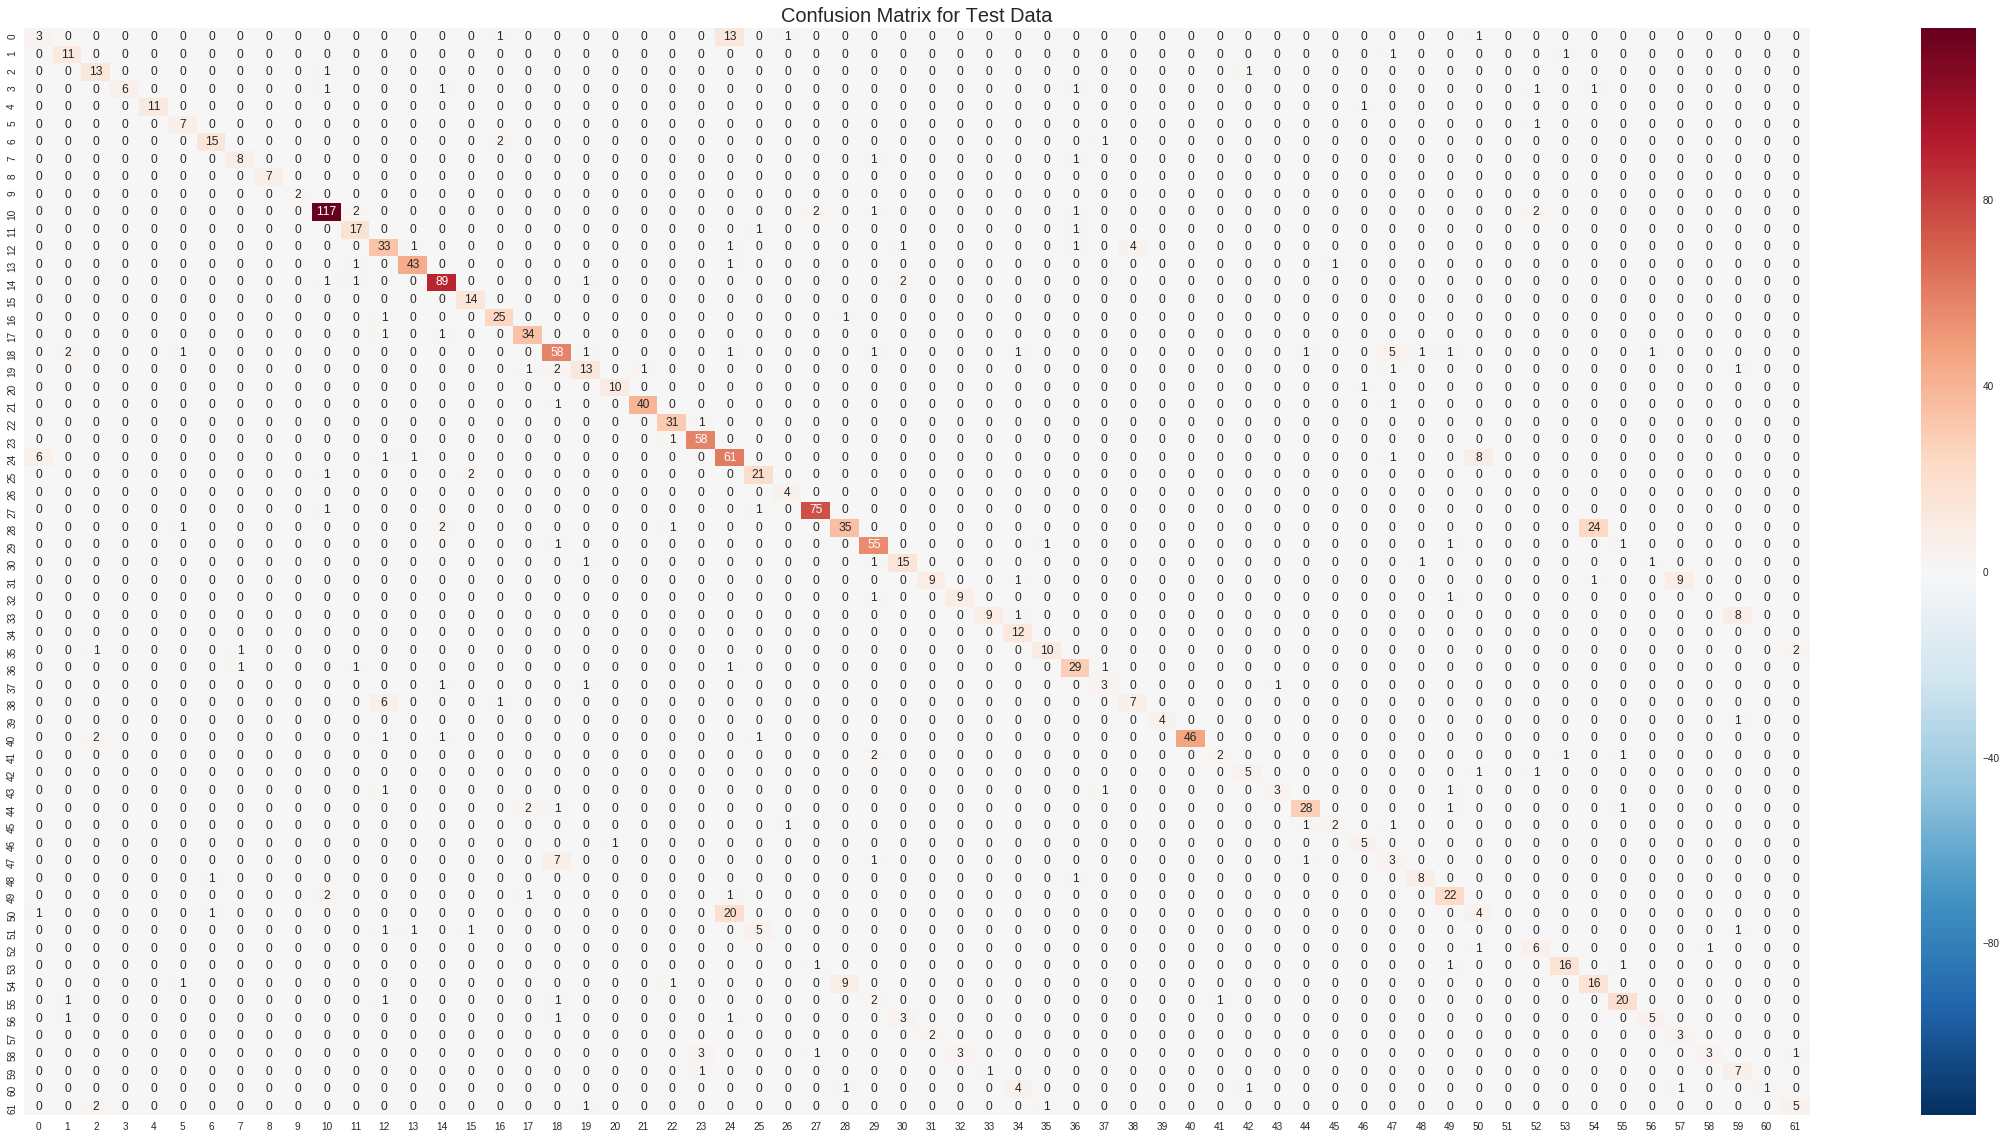

In [0]:
displayConfusionMatrix(y_true, y_classes)




**Question 1(b)**

Display the confusion matrix (rows are actual classes, columns
are predicted classes). An entry is 1 if the truth agrees with the
prediction. Display the confusion matrix as an image. Comment
on the confusion matrix you obtained

**Solution**: The confusion matrix is displayed above. 
Upon observing the confusion matrix, it can be infered that its close to being a diagonal matrix. This is expected due to the accuracy of the model on test data (0.7751827202011774). The low presence of non-zero positive values in the non-diagonal elements of the matrix is also attributed to the accuracy of the model on the test dataset. But since the accuracy is not as high as 90%, we do see some large outliers from the diagonal of the matrix (Ex. the value 25 at the intersection of 50 and 24). The confusion matrix gives us an intuitive representational picture of the model's accuracy. The more the confusion matrix is like a diaonal, the higher the accuracy of the model. 

**Question 1(c)**
Focus on the first convolution layer. Examine the feature maps
and comment on what they evolved to detect. Be specific and cast
your answer in terms of the task i.e. what of the characters are
they detecting

**Solution**
As seen in the figures below (for the letters 'h', 'f', 'v' and 'o'), the first convolutional layer seems to detect the straight edges well. This is apparent in the case of 'h', 'o' and 'f' wherin the conv. layer highlights the horizontal and vertical edges of the letter. In the case of 'v', the diagonal straight edges are detected by the layer. Therefore, we can infer that the first conv. layer has evolved to detect the different straight edges (as shown in the different feature maps) of each letter/digit.

(1, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


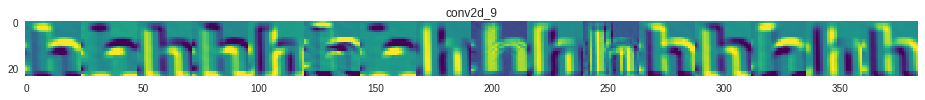

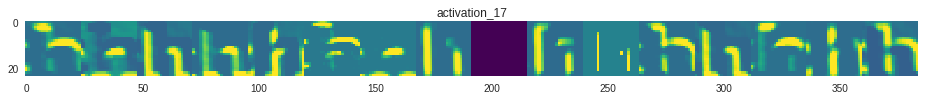

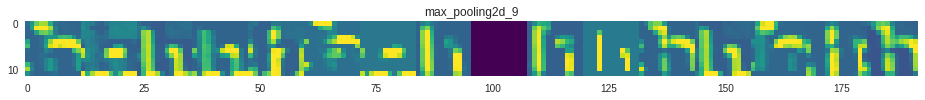

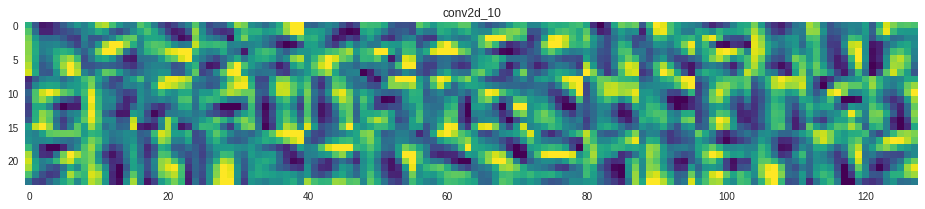

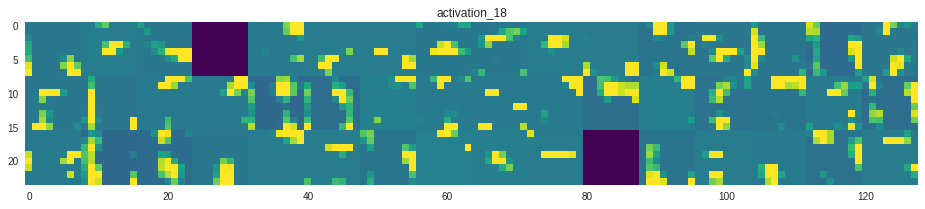

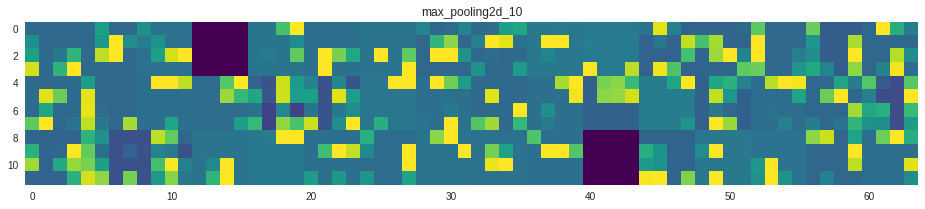

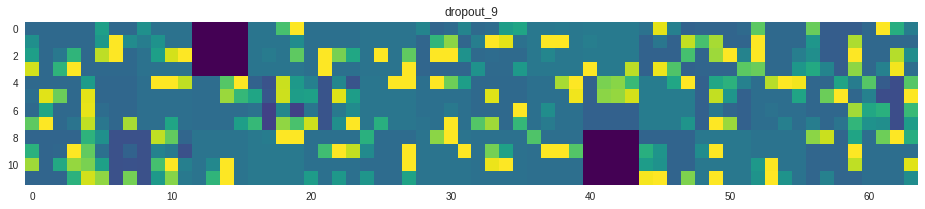

In [0]:
displayLayers("data/test/Sample044/img044-00039.png")

(1, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


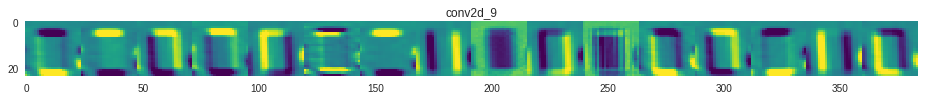

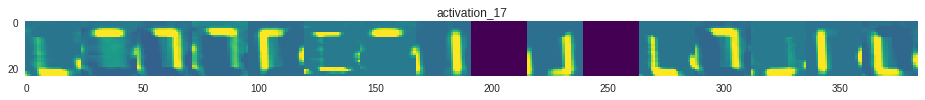

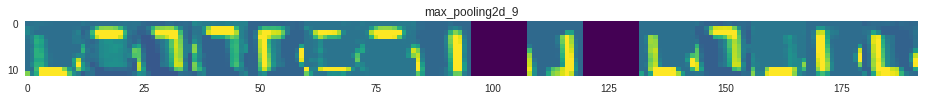

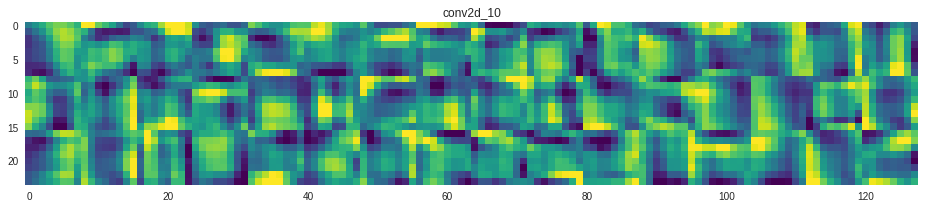

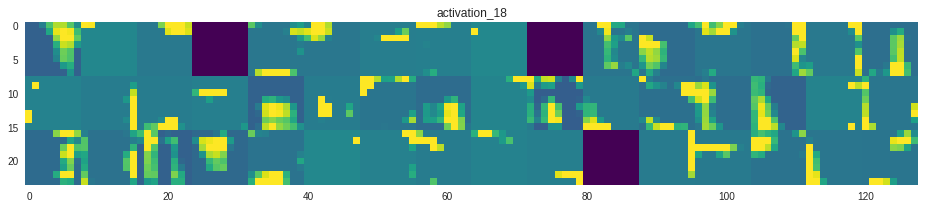

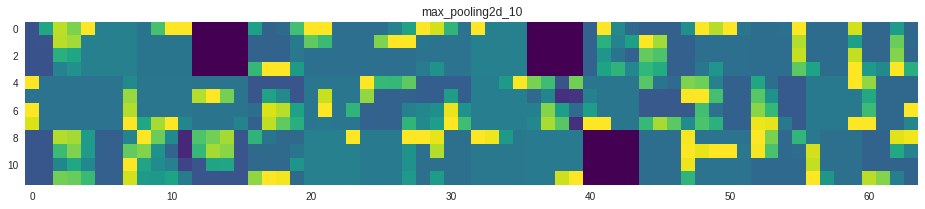

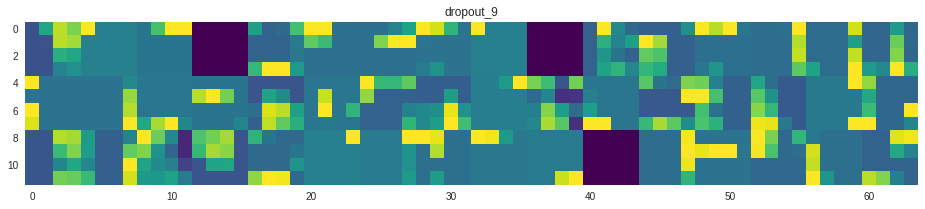

In [0]:
displayLayers("data/test/Sample048/img048-00042.png")

(1, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


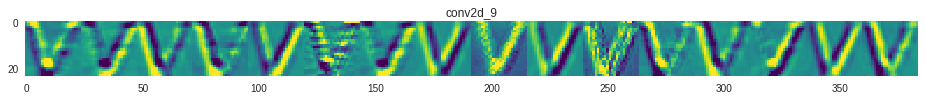

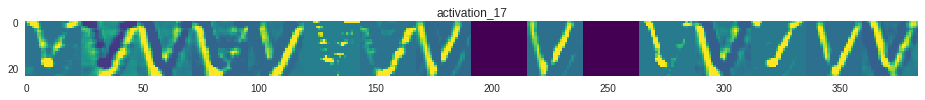

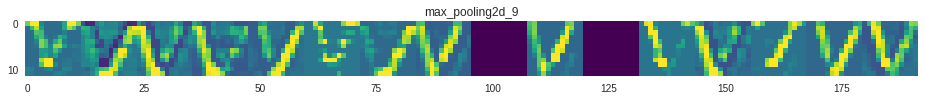

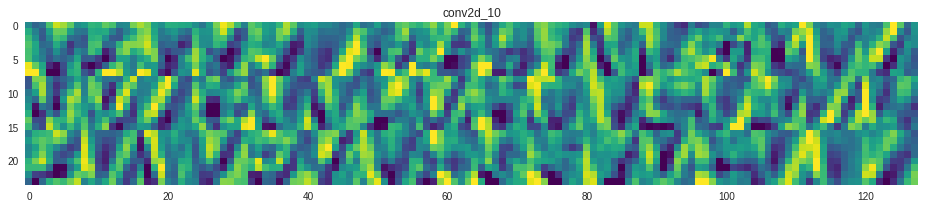

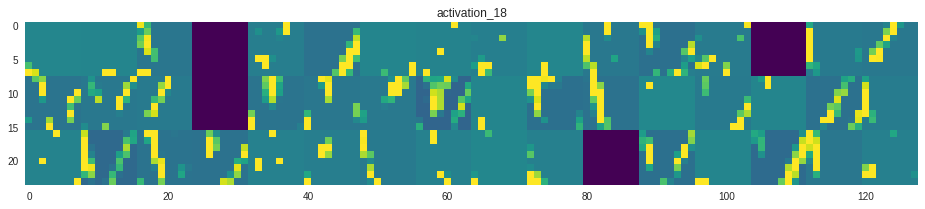

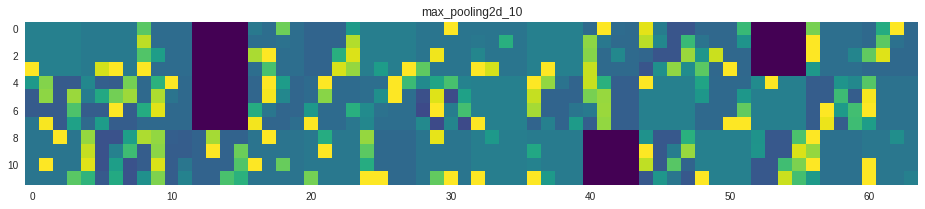

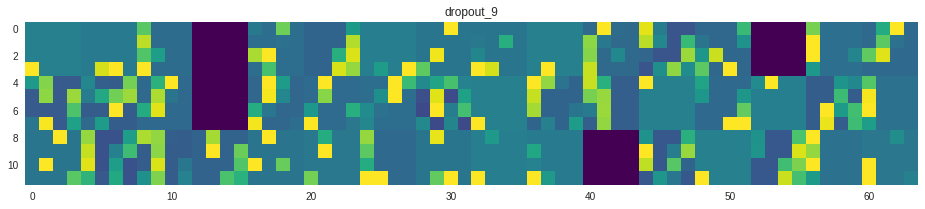

In [0]:
displayLayers("data/test/Sample032/img032-00044.png")

(1, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


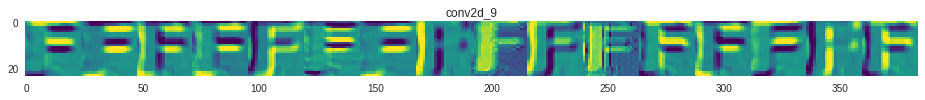

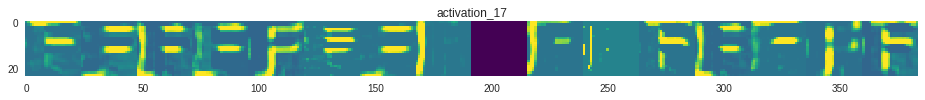

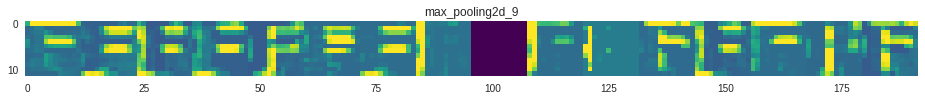

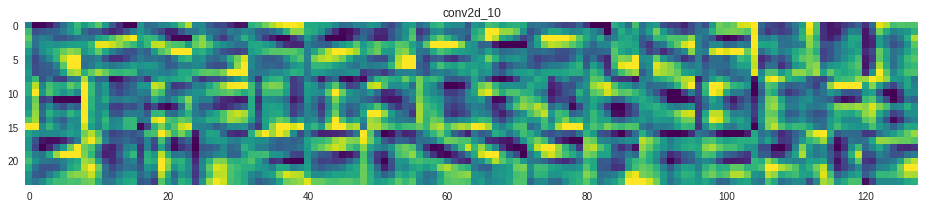

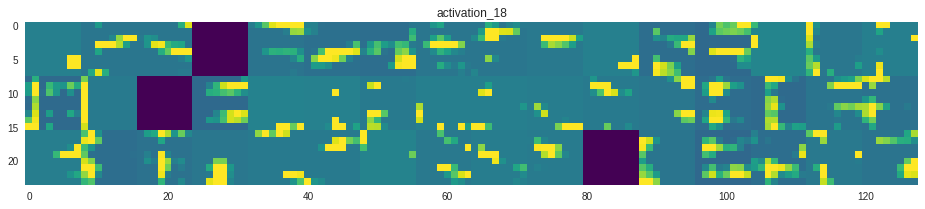

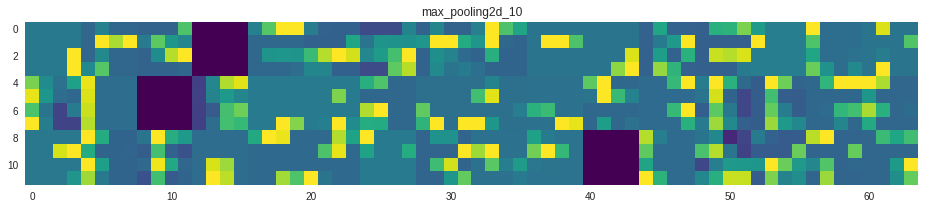

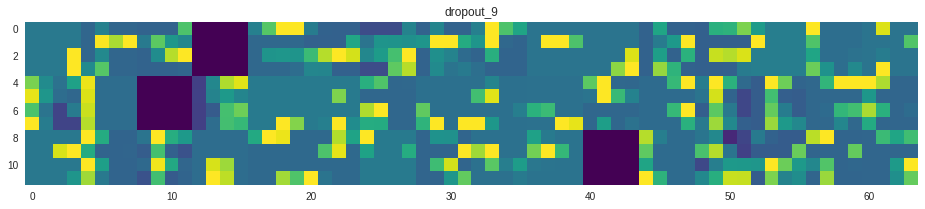

In [0]:
displayLayers("data/test/Sample016/img016-00032.png")

**Question 1(d)**
Focus on your last convolution layer. Examine the feature maps and
comment on what they evolved to detect. Be specific and cast
your answer in terms of the task i.e. what of the characters are
they detecting and in terms of what the earlier convolution layers
detected.

**Solution**
As seen in the figures below (for the letters 'h', 'f', 'v' and 'o'), the last convolutional layer seems to detect features that are not intuitive to us. The output in this layer seems to be somewhat abstract. This is expected since this latter conv. layers are supposed to evolve to detect spatial arrangements and characteristics that are not plainly intuitive to human beings. Also, due to the max pooling and dropout effects of the previous layers, the images that are sent to the last conv. layer are relatively highly convoluted and unrecognizable by the human eye. But, this is where, the learnable filters of the last conv. layer evolves to detect high dimension features that might not be captured by existing first principles. Additionally, as we can observe, the last layer (or second conv. layer) detects and highlights portions different from the first one, it is acting to find completely different features from the previous layers.  The yellow portions in the first conv. layer are mostly black or green in the last conv. layer. 

**Question 2**
What does stride control in a CNN. When would you use a larger/smaller
stride? Be specific.

**Solution**
The stride controls the spatial dimension of the output. Smaller strides lead to higher output volume. Larger strides lead to lower output volume. Therefore, larger strides can be used when we desire (i) low memory for output (ii) to reduce overfitting in image processing. A smaller stride would be used when we wish to capture the finer details of an image. that is complex in terms of the number attributes.  For example an extremely detailed painting On the other hand, a larger stride can be used on simpler (w.r.t number of attributes) images that are spatially less complex and have simliar neigbouring pixels around each pixel. For example, for an image with large patches of the same colour. Technically, larger strides can also be used to replace max pooling layers as well. 
